In [1]:
%matplotlib inline

from functools import partial
from pprint import pprint
import random
from collections import deque
import numpy as np
from matplotlib import pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet50
from torch.utils.data import DataLoader
from torch import nn, optim
import wids


/home/tmb/proj/webdataset/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# helpers

import time

def enumerate_report(seq, delta, growth=1.0):
    last = 0
    count = 0
    for count, item in enumerate(seq):
        now = time.time()
        if now - last > delta:
            last = now
            yield count, item, True
        else:
            yield count, item, False
        delta *= growth

In [3]:
# The standard TorchVision transformations.

transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transform_val = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# The dataset returns dictionaries. This is a small function we transform it
# with to get the augmented image and the label.

def make_sample(sample, val=False):
    image = sample[".jpg"]
    label = sample[".cls"]
    if val:
        return transform_val(image), label
    else:
        return transform_train(image), label


In [4]:
# These are standard PyTorch datasets. Download is incremental into the cache.

trainset = wids.ShardListDataset("gs://webdataset/fake-imagenet/imagenet-train.json", cache_dir="./_cache", keep=True)
valset = wids.ShardListDataset("gs://webdataset/fake-imagenet/imagenet-val.json", cache_dir="./_cache", keep=True)

trainset[0]

gs://webdataset/fake-imagenet/imagenet-train.json base: gs://webdataset/fake-imagenet name: imagenet-train nfiles: 1282 nbytes: 31242280960 samples: 128200 cache: ./_cache
gs://webdataset/fake-imagenet/imagenet-val.json base: gs://webdataset/fake-imagenet name: imagenet-val nfiles: 50 nbytes: 1219143680 samples: 5000 cache: ./_cache


{'.cls': 6,
 '.jpg': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512>,
 '.txt': 'a high quality color photograph of a lion',
 '__key__': '000000-000003',
 '__dataset__': None,
 '__index__': 0,
 '__shard__': 'gs://webdataset/fake-imagenet/imagenet-train-000000.tar',
 '__shardindex__': 0}

In [5]:
# Next, we add the transformation to the dataset. Transformations
# are executed in sequence. In fact, by default, there is a transformation
# that reads and decodes images.

trainset.add_transform(make_sample)
valset.add_transform(partial(make_sample, val=True))

print(trainset[0][0].shape, trainset[0][1])

torch.Size([3, 224, 224]) 6


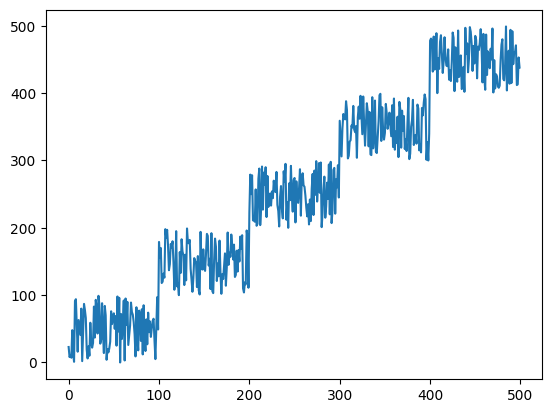

In [6]:
# We also need a sampler for the training set. There is a special
# sampler for sharded datasets that preserves locality of access.
# Of course, you can use a regular sampler as well.

trainsampler = wids.ShardedSampler(trainset)

plt.plot(list(trainsampler)[:500])

# Note that the sampler shuffles within each shard before moving on to
# the next shard. Furthermore, on the first epoch, the sampler
# uses the shards in order, but on subsequent epochs, it shuffles
# them. This makes testing and debugging easier. If you don't like
# this behavior, you can use shufflefirst=True

trainsampler.epoch = 0

In [7]:
# Create data loaders for the training and validation datasets

trainloader = DataLoader(trainset, batch_size=64, num_workers=4, sampler=trainsampler)
valloader = DataLoader(valset, batch_size=64, shuffle=False, num_workers=4)

images, classes = next(iter(trainloader))
print(images.shape, classes.shape)

torch.Size([64, 3, 224, 224]) torch.Size([64])


In [8]:
# The usual PyTorch model definition. We use an uninitialized ResNet50 model.

model = resnet50(pretrained=False)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

# Move the model to the GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/home/tmb/proj/webdataset/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/tmb/proj/webdataset/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [9]:
num_epochs = 5

losses, accuracies = deque(maxlen=100), deque(maxlen=100)

# Train the model
for epoch in range(num_epochs):
    for i, data, verbose in enumerate_report(trainloader, 5):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        pred = outputs.cpu().detach().argmax(dim=1, keepdim=True)
        correct = pred.eq(labels.cpu().view_as(pred)).sum().item()
        accuracy = correct / float(len(labels))

        losses.append(loss.item())
        accuracies.append(accuracy)

        if verbose and len(losses) > 5:
            print('[%d, %5d] loss: %.5f correct: %.5f' % (epoch + 1, i + 1, np.mean(losses), np.mean(accuracies)))
            running_loss = 0.0

print('Finished Training')

[1,    17] loss: 4.92683 correct: 0.06710
[1,    47] loss: 3.96740 correct: 0.09441
[1,    77] loss: 3.58122 correct: 0.12135
[1,   108] loss: 3.16504 correct: 0.16766
[1,   138] loss: 2.65427 correct: 0.23859
[1,   168] loss: 2.31222 correct: 0.31484
[1,   198] loss: 2.02836 correct: 0.38719
[1,   227] loss: 1.85584 correct: 0.43391
[1,   256] loss: 1.70971 correct: 0.47422
[1,   286] loss: 1.61993 correct: 0.50203
[1,   316] loss: 1.53397 correct: 0.52266
[1,   346] loss: 1.45882 correct: 0.54359
[1,   376] loss: 1.40004 correct: 0.56609
[1,   406] loss: 1.32444 correct: 0.59219
[1,   436] loss: 1.29822 correct: 0.60391
[1,   466] loss: 1.26308 correct: 0.61234
[1,   496] loss: 1.22564 correct: 0.61687
[1,   526] loss: 1.18832 correct: 0.62313
[1,   556] loss: 1.13894 correct: 0.64391
[1,   586] loss: 1.11371 correct: 0.65641
[1,   616] loss: 1.06668 correct: 0.67109
[1,   646] loss: 1.02194 correct: 0.68500
[1,   676] loss: 1.01167 correct: 0.68953
[1,   706] loss: 1.01116 correct: 